### Variational Inference in Python
Based on https://www.ritchievink.com/blog/2019/09/16/variational-inference-from-scratch/

In [1]:
import numpy as np
import torch
from torch import nn
from sklearn import datasets
import matplotlib.pyplot as plt

In [2]:
def load_dataset(n=150, n_tst=150):
    np.random.seed(43)

    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)

    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    y = (y - y.mean()) / y.std()
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    return y[:, None], x[:, None]

In [3]:
w0 = 0.125
b0 = 0.5
x_range = [-20, 60]
Z, X = load_dataset()

In [4]:
print(Z.shape)
print(X.shape)

(150, 1)
(150, 1)


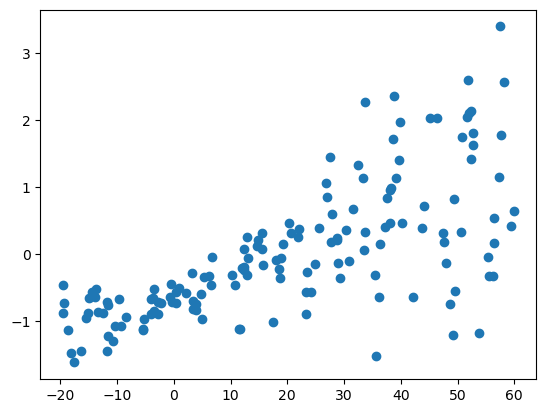

In [5]:
plt.scatter(X, Z)
plt.show()

### Build network

In [6]:
class VI(nn.Module):
    def __init__(self):
        super().__init__()

        # g_{phi}(x) used to parametrize the mean of the Gaussian variational distribution Q(y|x)
        self.q_mu = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

        # g_{phi}(x) used to parametrize the  of the Gaussian variational distribution Q(y|x)
        self.q_log_var = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def reparameterize(self, mu, log_var):
        # std cannot be negative, that's why the output of the network is treated as the log variance
        sigma = torch.exp(0.5 * log_var) + 1e-5
        eps = torch.randn_like(sigma)
        return mu + sigma * eps

    def forward(self, x):
        mu = self.q_mu(x)
        log_var = self.q_log_var(x)
        return self.reparameterize(mu, log_var), mu, log_var

### Define loss

In [7]:
# def loss(z, z_pred, mu, log_var):
#     """
#     Loss function of the Variational Auto-Encoder (eq. 10).
#     """
    
#     mse_loss = nn.MSELoss(reduction='sum') # reconstruction error
#     recon_error = mse_loss(z_pred, z)
#     kl_div = 0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var)) # analytical loss of KL-divergence assuming Gaussian prior and Gaussian posterior with diagonal covariance
#     return recon_error - kl_div

In [8]:
def ll_gaussian(z, mu, log_var):
    sigma = torch.exp(0.5 * log_var)
    return -0.5 * ((z - mu) / sigma)**2 - torch.log(sigma * torch.sqrt(2 * torch.tensor(np.pi)))

def elbo(z_pred, X, mu, log_var):
    # likelihood of observing y given Variational mu and sigma p(x|z)
    likelihood = ll_gaussian(X, mu, log_var)
    
    # prior probability of y_pred p_{theta}(z)
    log_prior = ll_gaussian(z_pred, 0, torch.log(torch.tensor(1.)))
    
    # variational probability of y_pred q_{phi}(z|x)
    log_p_q = ll_gaussian(z_pred, mu, log_var)
    
    # by taking the mean we approximate the expectation
    return (likelihood + log_prior - log_p_q).mean()

def loss(z_pred, X, mu, log_var):
    return -elbo(z_pred, X, mu, log_var)

### Fit the model

In [9]:
epochs = 1500

model = VI()
optim = torch.optim.Adam(model.parameters(), lr = 0.005)
print(model)

VI(
  (q_mu): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
  (q_log_var): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [10]:
X = torch.tensor(X, dtype=torch.float)
Z = torch.tensor(Z, dtype=torch.float)

In [11]:
train_loss = np.zeros(epochs)
for epoch in range(epochs):
    # clear out gradiants
    optim.zero_grad()

    # compute errors
    z_pred, mu, log_var = model(X)
    error = loss(z_pred, Z, mu, log_var)

    # backpropagation
    error.backward()
    optim.step()
    train_loss[epoch] = error.item()

### Draw samples from model

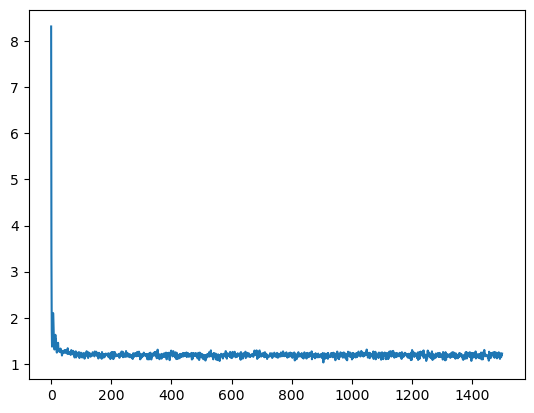

In [12]:
plt.plot(train_loss)
plt.show()

In [14]:
# draw samples from Q(theta)
with torch.no_grad():
    z = torch.cat([model(X)[0] for _ in range(1000)], dim=1)

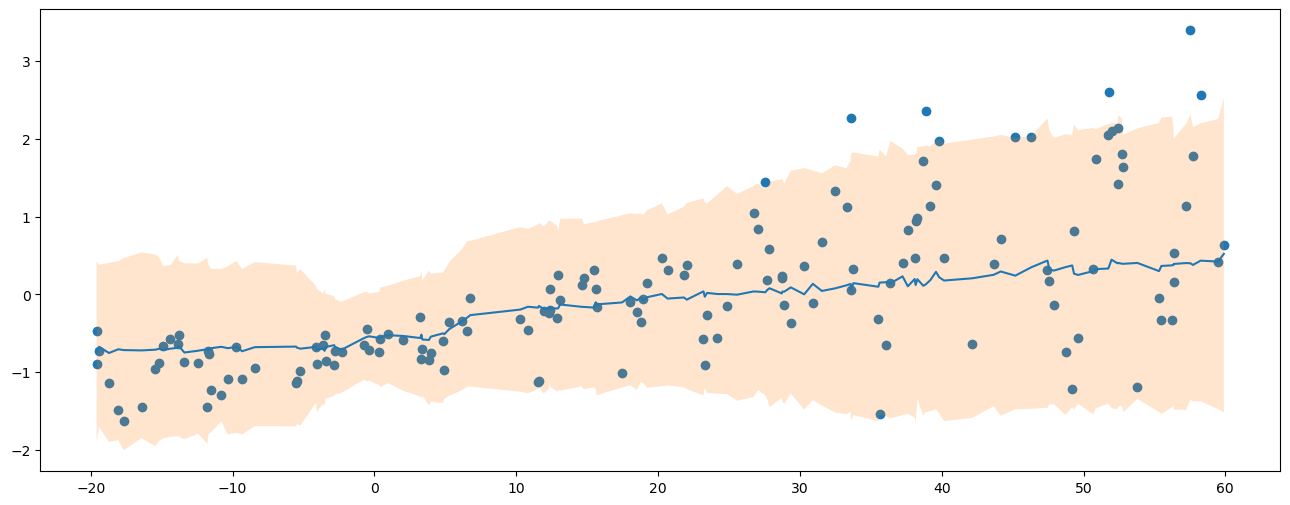

In [15]:
# Get some quantiles
q1, mu, q2 = np.quantile(z, [0.05, 0.5, 0.95], axis=1)

plt.figure(figsize=(16, 6))
plt.scatter(X, Z)
plt.plot(X, mu)
plt.fill_between(X.flatten(), q1, q2, alpha=0.2)
plt.show()

In [16]:
# draw samples from Q(theta)
with torch.no_grad():
    z_pred, mu, log_var = model(X)

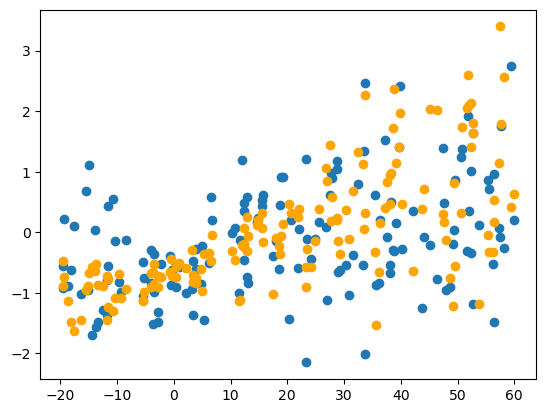

In [17]:
plt.scatter(X, z_pred)
plt.scatter(X, Z, c='orange')
plt.show()